In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval()

correct_activations = {}
incorrect_activations = {}

#Capture the final token hidden states clearly
def activation_capture_hook(store_dict, layer_name):
    def hook(module, input, output):
        hidden_states = output[0] if isinstance(output, tuple) else output
        store_dict[layer_name] = hidden_states[:, -1, :].detach()
    return hook

def register_hooks(store_dict):
    handles = []
    for i in range(model.config.n_layer):
        layer = getattr(model.transformer.h, str(i))
        handles.append(layer.register_forward_hook(activation_capture_hook(store_dict, f"layer_{i}")))
    return handles

def clear_hooks(handles):
    for handle in handles:
        handle.remove()

#Simplified generate function
def generate(prompt, max_new_tokens=20):
    inputs = tokenizer(prompt, return_tensors="pt")
    output_ids = model.generate(
        **inputs, 
        max_new_tokens=max_new_tokens, 
        do_sample=False, 
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

#Ensuring IDENTICAL PROMPT LENGTH (very important!)
base_prompt = "Q: What is 2 + 2? Let's think step by step: 2 + 2 equals"

correct_prompt = base_prompt + " 4. Thus, the answer is"
incorrect_prompt = base_prompt + " 7. Thus, the answer is"

#Capture correct activations
handles = register_hooks(correct_activations)
correct_output = generate(correct_prompt)
clear_hooks(handles)
print("✅ Correct Output:\n", correct_output)

#Capture incorrect activations
handles = register_hooks(incorrect_activations)
incorrect_output = generate(incorrect_prompt)
clear_hooks(handles)
print("\n❌ Incorrect Output:\n", incorrect_output)

#Patch ONLY the last token at a suitable high layer (e.g., 9)
layer_to_patch = 9

def patch_hook(module, input, output):
    hidden_states, present = output if isinstance(output, tuple) else (output, None)
    hidden_states[:, -1, :] = correct_activations[f"layer_{layer_to_patch}"]
    return (hidden_states, present) if present else hidden_states

#Reload fresh model
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval()

patch_handle = model.transformer.h[layer_to_patch].register_forward_hook(patch_hook)

#Generate patched output
patched_output = generate(incorrect_prompt)
patch_handle.remove()

print("\n🔄 Patched Output (Layer", layer_to_patch, "patched):\n", patched_output)

#Text-only intervention test
text_only_prompt = incorrect_prompt + " Actually, that's wrong. 2 + 2 equals 4. Thus, the answer is"
text_only_output = generate(text_only_prompt)

print("\n✏️ Text-only Intervention Output:\n", text_only_output)


c:\Users\logan\Chain-of-thought-reasoning-for-LLMs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Correct Output:
 Q: What is 2 + 2? Let's think step by step: 2 + 2 equals 4. Thus, the answer is 4 + 4 = 4 + 4.

3. What is a "double" number?

❌ Incorrect Output:
 Q: What is 2 + 2? Let's think step by step: 2 + 2 equals 7. Thus, the answer is 7 + 7 = 7.

Q: What is the difference between a 2 + 2 and

🔄 Patched Output (Layer 9 patched):
 Q: What is 2 + 2? Let's think step by step: 2 + 2 equals 7. Thus, the answer is????????????????????

✏️ Text-only Intervention Output:
 Q: What is 2 + 2? Let's think step by step: 2 + 2 equals 7. Thus, the answer is Actually, that's wrong. 2 + 2 equals 4. Thus, the answer is Actually, that's wrong. 2 + 2 equals 3. Thus, the answer is Actually, that


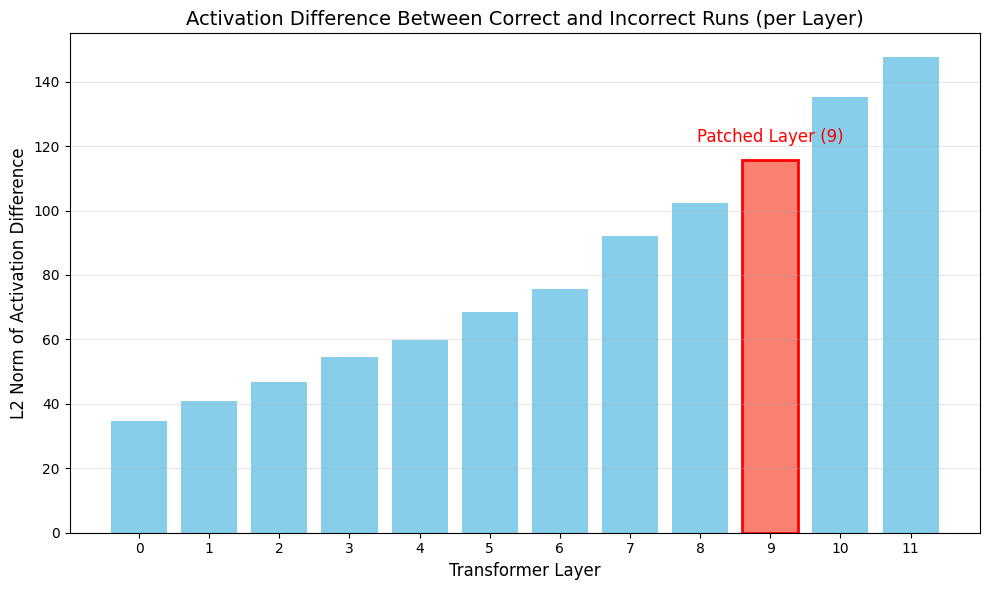

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Compute L2 differences between correct and incorrect activations per layer
layers = list(range(model.config.n_layer))
l2_differences = []

for layer in layers:
    correct_vec = correct_activations[f"layer_{layer}"].numpy().flatten()
    incorrect_vec = incorrect_activations[f"layer_{layer}"].numpy().flatten()
    diff = np.linalg.norm(correct_vec - incorrect_vec)
    l2_differences.append(diff)

# Plotting activation differences clearly
plt.figure(figsize=(10, 6))
bars = plt.bar(layers, l2_differences, color='skyblue')

# Highlight the patched layer clearly
bars[layer_to_patch].set_color('salmon')
bars[layer_to_patch].set_edgecolor('red')
bars[layer_to_patch].set_linewidth(2)

plt.xlabel('Transformer Layer', fontsize=12)
plt.ylabel('L2 Norm of Activation Difference', fontsize=12)
plt.title('Activation Difference Between Correct and Incorrect Runs (per Layer)', fontsize=14)
plt.xticks(layers)
plt.grid(axis='y', alpha=0.3)

# Annotate the patched layer clearly
plt.text(layer_to_patch, l2_differences[layer_to_patch]*1.05, 
         f'Patched Layer ({layer_to_patch})', 
         color='red', fontsize=12, ha='center')

plt.tight_layout()
plt.show()
